In [1]:
import os
import re
import pandas as pd
import sentencepiece as spm
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [2]:
pip install Bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 33.8 MB/s eta 0:00:00


In [3]:
from Bio import SeqIO

In [4]:
def join_cds_ncrna(input_file,output_file):
  merged_sequence=""
  for record in SeqIO.parse(input_file,"fasta"):
    merged_sequence+=str(record.seq)

  with open(output_file,"w") as file:
    file.write(merged_sequence)

In [5]:
genome_sequences_dir = "genome_sequences"
tokenizers_dir = "tokenizers"
subsampled_genomes_dir = "subsampled_genomes"
chunk_size = 4192
default_subsample_size = 10**6

os.makedirs(subsampled_genomes_dir, exist_ok=True)
os.makedirs(tokenizers_dir, exist_ok=True)
os.makedirs(genome_sequences_dir, exist_ok=True)


In [8]:
join_cds_ncrna('Arabidopsis_thaliana.TAIR10.cds.all (3).fa','genome_sequences/Arabidopsis_thaliana_cds.txt')

In [9]:
#modify the name of the organism as well as the
org = "Arabidopsis thaliana"
genome_filename = f"{org.replace(' ', '_')}_cds.txt"
#genome_filename = f"{org.replace(' ', '_')}_ncrna.txt" if we will tokenize ncrna
vocab_file ="tokenizers/"+org+"_1000_sp.vocab"
model_to_load="tokenizers/"+org+"_1000_sp.model"


genome size: 4228014
processed genome saved to subsampled_genomes/Arabidopsis_thaliana_processed.txt
processed genome saved to subsampled_genomes/Arabidopsis_thaliana_subsampled.txt
subsampled_genomes/Arabidopsis_thaliana_processed.txt contains 1009 lines.
 processed genome length: 4229023 bases
 subsampled genome length: 2000478 bases
Using subsampled genome for training.
Training with vocab size: 1000, model prefix: tokenizers/Arabidopsis thaliana_1000_sp
model and vocab files created: tokenizers/Arabidopsis thaliana_1000_sp.model, tokenizers/Arabidopsis thaliana_1000_sp.vocab
Sample vocab for vocab size 1000: ['AA', 'TG', 'TC', 'AG', 'TT', 'AC', 'ATG', 'GG', 'TTC', 'GC']
Vocab size: 1000, compression factor: 0.23074426905871173, number of tokens: 970024
Training with vocab size: 11000, model prefix: tokenizers/Arabidopsis thaliana_11000_sp
model and vocab files created: tokenizers/Arabidopsis thaliana_11000_sp.model, tokenizers/Arabidopsis thaliana_11000_sp.vocab
Sample vocab for vo

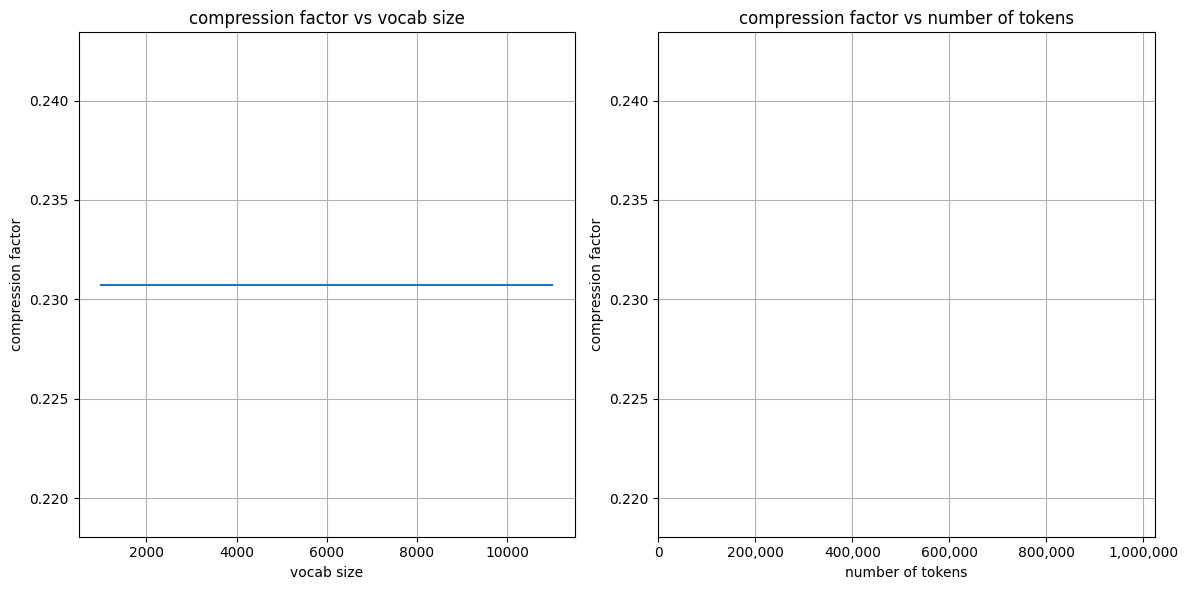

[('AAAC', 2103), ('AAGC', 2097), ('AATG', 2088), ('ATTC', 2037), ('TATG', 2037), ('ATGG', 2036), ('TTTC', 2015), ('AATC', 1994), ('TTGG', 1988), ('TAC', 1987), ('TTTG', 1973), ('AGAG', 1967), ('TCTC', 1959), ('AAGG', 1948), ('TAG', 1947), ('ACG', 1946), ('TTGC', 1938), ('TTCC', 1931), ('ACC', 1929), ('TCG', 1918), ('AAAG', 1913), ('TGC', 1898), ('ATGC', 1886), ('ATCC', 1873), ('ATTG', 1861), ('TTAC', 1853), ('AATGG', 1833), ('AAC', 1832), ('AGC', 1828), ('TTG', 1818)]


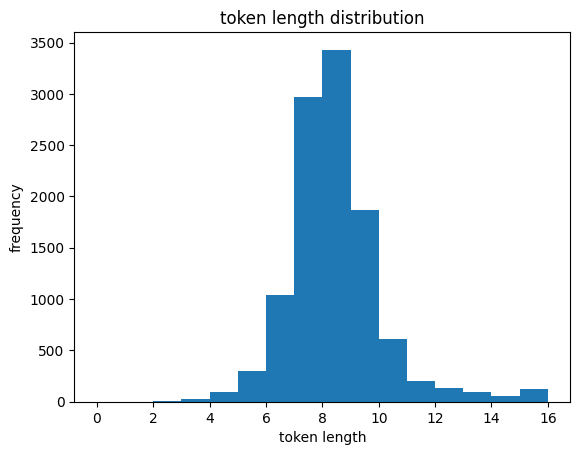

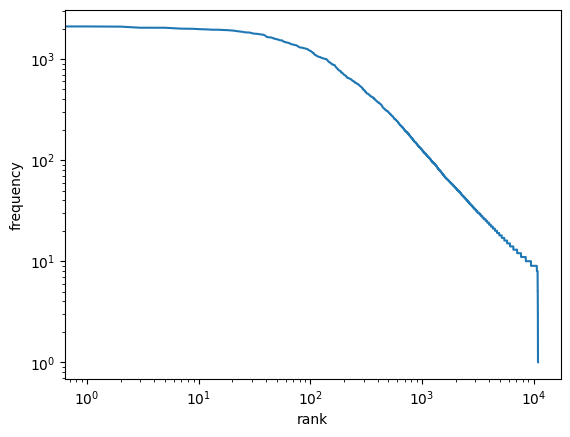

In [ ]:
def load_genome_sequence(filename):
    path = os.path.join(genome_sequences_dir, filename)
    with open(path, 'r') as f:
        genome = f.read().upper().replace('\n', '')
    return genome

genome = load_genome_sequence(genome_filename)
print(f"genome size: {len(genome)}")

def process_genome_into_chunks(genome, path, chunk_size=chunk_size):
    chunks = [genome[i:i+chunk_size] + '.' for i in range(0, len(genome), chunk_size)]
    with open(path, 'w') as f:
        for chunk in chunks:
            f.write(chunk + '\n')
    print(f"processed genome saved to {path}")

processed_genome_path = os.path.join(subsampled_genomes_dir, f"{org.replace(' ', '_')}_processed.txt")
process_genome_into_chunks(genome, processed_genome_path)

def subsample_genome(genome, size=default_subsample_size):
    if len(genome) <= size:
        return genome
    elif len(genome) <= 2 * size:
        return genome
    return genome[:size] + genome[-size:]

def save_subsampled_genome(org, subsample):
    subsample_path = os.path.join(subsampled_genomes_dir, f"{org.replace(' ', '_')}_subsampled.txt")
    process_genome_into_chunks(subsample, subsample_path)
    return subsample_path

subsampled_sequence = subsample_genome(genome)
subsampled_genome_path = save_subsampled_genome(org, subsampled_sequence)

def check_processed_file(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        print(f"{path} contains {len(lines)} lines.")

check_processed_file(processed_genome_path)

def get_sequence_length(file_path):
    with open(file_path, 'r') as f:
        return len(f.read().replace('\n', ''))

processed_length = get_sequence_length(processed_genome_path)
subsampled_length = get_sequence_length(subsampled_genome_path)

print(f" processed genome length: {processed_length} bases")
print(f" subsampled genome length: {subsampled_length} bases")

training_genome_path = subsampled_genome_path if subsampled_length < processed_length else processed_genome_path
print(f"Using {'subsampled' if subsampled_length < processed_length else 'processed'} genome for training.")

def train_sentencepiece_tokenizer_bpe(input_file, model_prefix, vocab_size, method="sp"):
    model_prefix = f"{model_prefix}_{method}"  # Ensure the model and vocab files are named with the "sp" prefix
    model_file = model_prefix + ".model"
    vocab_file = model_prefix + ".vocab"

    # Check if the model and vocab files already exist
    if os.path.exists(model_file) and os.path.exists(vocab_file):
        print(f"Model and vocab files already exist: {model_file}, {vocab_file}")
        return
    try:
        spm.SentencePieceTrainer.train(
            input=input_file,
            model_prefix=model_prefix,
            vocab_size=vocab_size,
            model_type='bpe',
            character_coverage=0.9995,
            max_sentence_length=5000,
            hard_vocab_limit=False
        )
        if os.path.exists(model_file) and os.path.exists(vocab_file):
            print(f"model and vocab files created: {model_file}, {vocab_file}")
        else:
            print(f"error, model or vocab file not created for {model_prefix}")
    except Exception as e:
        print(f"error occurred during training: {e}")
        raise e

def load_tokenizer_vocab(model_prefix,vocab_file):
    vocab = pd.read_csv(vocab_file, sep='\t', header=None)
    vocab = vocab[0].tolist()
    vocab = [v for v in vocab if v and re.match(r'^[ACGT]+$', v)]
    return vocab

def calculate_compression_factor(genome, tokens, vocab):
    total_length = len(genome)
    encoded_length = len(tokens)
    vocab_length = sum(len(token) for token in vocab)
    compression_factor = (encoded_length + vocab_length) / total_length
    return compression_factor

def evaluate_vocab_size(genome, processed_genome_path, vocab_size, model_to_load, method="sp"):
    model_prefix = os.path.join(tokenizers_dir, f"{org}_{vocab_size}")
    print(f"Training with vocab size: {vocab_size}, model prefix: {model_prefix}_{method}")
    train_sentencepiece_tokenizer_bpe(processed_genome_path, model_prefix, vocab_size, method)


    sp = spm.SentencePieceProcessor()
    sp.load(model_to_load)
    tokens = sp.encode_as_pieces(genome)

    vocab = load_tokenizer_vocab(model_prefix,vocab_file)
    print(f"Sample vocab for vocab size {vocab_size}: {vocab[:10]}")
    compression_factor = calculate_compression_factor(genome, tokens, vocab)
    print(f'Vocab size: {vocab_size}, compression factor: {compression_factor}, number of tokens: {len(tokens)}')
    return (vocab_size, compression_factor, len(tokens))

def extended_search_vocab_size(genome, processed_genome_path, initial_vocab_size=1000, step_size=5000, max_vocab_size=80000, threshold=1):
    genome_length = len(genome)
    if genome_length > 10**6:
        step_size = 10000
        max_vocab_size = 100000

    vocab_size = initial_vocab_size
    compression_factors = []
    optimal_vocab_size = None

    while vocab_size <= max_vocab_size:
        result = evaluate_vocab_size(genome, processed_genome_path, vocab_size, model_to_load)
        if result:
            vocab_size, compression_factor, num_tokens = result
            compression_factors.append(result)
            if len(compression_factors) > 1 and abs(compression_factors[-1][1] - compression_factors[-2][1]) < threshold:
                optimal_vocab_size = vocab_size
                break
        vocab_size += step_size

    if optimal_vocab_size is None:
        min_compression = min(compression_factors, key=lambda x: x[1])
        optimal_vocab_size = min_compression[0]

    return compression_factors, optimal_vocab_size

compression_factors, optimal_vocab_size = extended_search_vocab_size(
    genome, processed_genome_path, initial_vocab_size=1000, step_size=5000, max_vocab_size=80000, threshold=1)

if optimal_vocab_size is None:
    print(f"No optimal vocab size found. Compression factors: {compression_factors}")
else:
    print(f"Optimal vocab size for {org}: {optimal_vocab_size}")

def load_tokenizer(org, vocab_size, method="sp"):
    model_path = os.path.join(tokenizers_dir, f"{org}_{vocab_size}_{method}.model")
    sp = spm.SentencePieceProcessor(model_file=model_path)
    return sp


def plot_results(compression_factors):
    vocab_sizes, compression_values, num_tokens = zip(*compression_factors)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(vocab_sizes, compression_values)
    plt.xlabel('vocab size')
    plt.ylabel('compression factor')
    plt.title('compression factor vs vocab size')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(num_tokens, compression_values)
    plt.xlabel('number of tokens')
    plt.ylabel('compression factor')
    plt.title('compression factor vs number of tokens')
    plt.grid(True)
    plt.xlim(left=0)
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

    plt.tight_layout()
    plt.show()

def analyze_tokens(tokens):
    tokcounts = Counter(tokens).most_common()
    print(tokcounts[:30])

    plt.hist([len(t[0]) for t in tokcounts],
            bins=np.arange(0,max([len(t[0]) for t in tokcounts])+1))
    plt.xlabel('token length')
    plt.ylabel('frequency')
    plt.title('token length distribution')
    plt.show()

    TC = [t[1] for t in tokcounts]
    plt.plot(np.arange(0, len(TC), 1), TC)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('rank')
    plt.ylabel('frequency')
    plt.show()


plot_results(compression_factors)

sp_model = load_tokenizer(org, optimal_vocab_size, method="sp")
sp_tokens = sp_model.encode_as_pieces(genome)
analyze_tokens(sp_tokens)




genome size: 4228014
processed genome saved to subsampled_genomes/Arabidopsis_thaliana_processed.txt
processed genome saved to subsampled_genomes/Arabidopsis_thaliana_subsampled.txt
subsampled_genomes/Arabidopsis_thaliana_processed.txt contains 1009 lines.
 processed genome length: 4229023 bases
 subsampled genome length: 2000478 bases
Using subsampled genome for training.
K-mers saved to subsampled_genomes/Arabidopsis thaliana_kmers.txt
subsampled_genomes/Arabidopsis thaliana_kmers.txt contains 4228009 kmers
first 10 kmers: ['ATGACG', 'TGACGG', 'GACGGC', 'ACGGCG', 'CGGCGA', 'GGCGAC', 'GCGACG', 'CGACGA', 'GACGAA', 'ACGAAC']
training w vocab size: 1000, model prefix: tokenizers/Arabidopsis thaliana_1000_kmer
Model and vocab files created: tokenizers/Arabidopsis thaliana_1000_kmer.model, tokenizers/Arabidopsis thaliana_1000_kmer.vocab
Vocab size: 1000, compression factor: 0.34170747778980864, number of tokens: 1444162
K-mers saved to subsampled_genomes/Arabidopsis thaliana_kmers.txt
subs

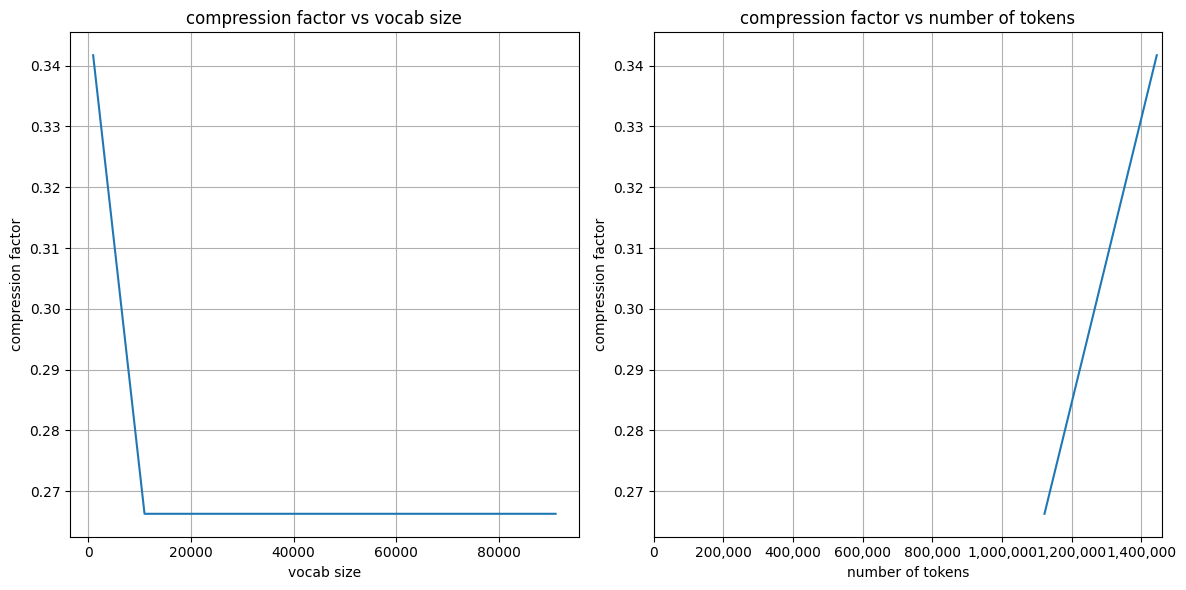

[('ATG', 36088), ('TTC', 27094), ('AAG', 26200), ('ATGG', 23330), ('TGG', 22982), ('AATG', 19612), ('ATC', 17696), ('AAC', 16553), ('TTG', 16369), ('AGAA', 16356), ('AGG', 16279), ('TCC', 15752), ('AGC', 15610), ('TC', 13629), ('ACC', 12414), ('AAAA', 12244), ('TTTC', 11951), ('TGC', 11730), ('TG', 10913), ('TCG', 10570), ('AGAG', 10471), ('GCC', 10172), ('ATGC', 10085), ('AAAG', 10010), ('ACG', 9805), ('AATC', 9584), ('AAGC', 9475), ('ATTC', 9334), ('GGC', 8993), ('TTTG', 8823)]


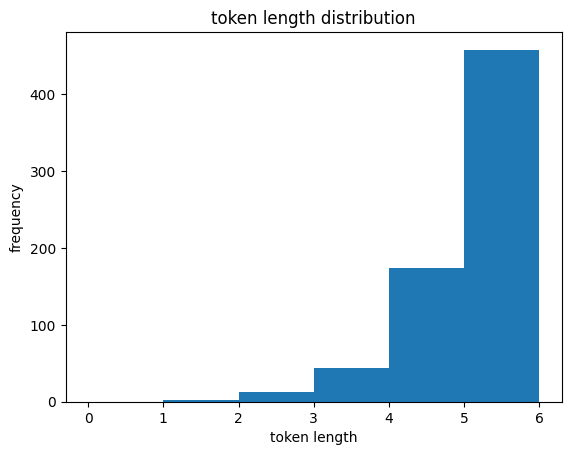

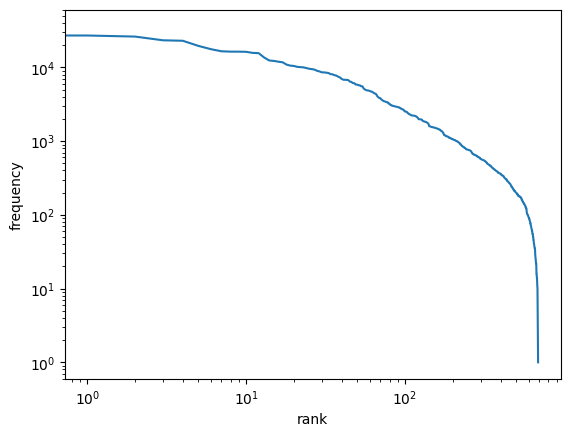

In [ ]:
kmer_size = 6

def load_genome_sequence(filename):
    path = os.path.join(genome_sequences_dir, filename)
    with open(path, 'r') as f:
        genome = f.read().upper().replace('\n', '')
    return genome

genome = load_genome_sequence(genome_filename)
print(f"genome size: {len(genome)}")

def process_genome_into_chunks(genome, path, chunk_size=chunk_size):
    chunks = [genome[i:i+chunk_size] + '.' for i in range(0, len(genome), chunk_size)]
    with open(path, 'w') as f:
        for chunk in chunks:
            f.write(chunk + '\n')
    print(f"processed genome saved to {path}")

processed_genome_path = os.path.join(subsampled_genomes_dir, f"{org.replace(' ', '_')}_processed.txt")
process_genome_into_chunks(genome, processed_genome_path)

def subsample_genome(genome, size=default_subsample_size):
    if len(genome) <= size:
        return genome
    elif len(genome) <= 2 * size:
        return genome
    return genome[:size] + genome[-size:]

def save_subsampled_genome(org, subsample):
    subsample_path = os.path.join(subsampled_genomes_dir, f"{org.replace(' ', '_')}_subsampled.txt")
    process_genome_into_chunks(subsample, subsample_path)
    return subsample_path

subsampled_sequence = subsample_genome(genome)
subsampled_genome_path = save_subsampled_genome(org, subsampled_sequence)

def check_processed_file(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        print(f"{path} contains {len(lines)} lines.")

check_processed_file(processed_genome_path)

def get_sequence_length(file_path):
    with open(file_path, 'r') as f:
        return len(f.read().replace('\n', ''))

processed_length = get_sequence_length(processed_genome_path)
subsampled_length = get_sequence_length(subsampled_genome_path)

print(f" processed genome length: {processed_length} bases")
print(f" subsampled genome length: {subsampled_length} bases")

training_genome_path = subsampled_genome_path if subsampled_length < processed_length else processed_genome_path
print(f"Using {'subsampled' if subsampled_length < processed_length else 'processed'} genome for training.")

def generate_kmers(sequence, k):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

def save_kmers_to_file(kmers, file_path):
    with open(file_path, 'w') as f:
        for kmer in kmers:
            f.write(kmer + '\n')
    print(f"K-mers saved to {file_path}")

def train_sentencepiece_tokenizer_kmer(input_file, model_prefix, vocab_size, method="kmer"):
    model_prefix = f"{model_prefix}_{method}" if method not in model_prefix else model_prefix
    model_file = model_prefix + ".model"
    vocab_file = model_prefix + ".vocab"

    if os.path.exists(model_file) and os.path.exists(vocab_file):
        print(f"Model and vocab files already exist: {model_file}, {vocab_file}")
        return model_prefix
    try:
        spm.SentencePieceTrainer.train(
            input=input_file,
            model_prefix=model_prefix,
            vocab_size=vocab_size,
            model_type='bpe',
            character_coverage=0.9995,
            max_sentence_length=5000,
            hard_vocab_limit=False
        )
        if os.path.exists(model_file) and os.path.exists(vocab_file):
            print(f"Model and vocab files created: {model_file}, {vocab_file}")
        else:
            raise FileNotFoundError(f"Error: model or vocab file not created for {model_prefix}")
    except Exception as e:
        print(f"Error occurred during training: {e}")
        raise e
    return model_prefix

def load_tokenizer_vocab(model_prefix):
    vocab_file = model_prefix + ".vocab"
    vocab = pd.read_csv(vocab_file, sep='\t', header=None)
    vocab = vocab[0].tolist()
    vocab = [v for v in vocab if v and re.match(r'^[ACGT]+$', v)]
    return vocab

def calculate_compression_factor(genome, tokens, vocab):
    total_length = len(genome)
    encoded_length = len(tokens)
    vocab_length = sum(len(token) for token in vocab)
    compression_factor = (encoded_length + vocab_length) / total_length
    return compression_factor

def evaluate_vocab_size(genome, kmers, processed_genome_path, vocab_size, method="kmer"):
    kmer_file_path = os.path.join(subsampled_genomes_dir, f"{org}_kmers.txt")
    save_kmers_to_file(kmers, kmer_file_path)

    with open(kmer_file_path, 'r') as f:
        kmer_lines = f.readlines()
        kmer_lines = [kmer.strip() for kmer in kmer_lines]
        print(f"{kmer_file_path} contains {len(kmer_lines)} kmers")
        print(f"first 10 kmers: {kmer_lines[:10]}")

    model_prefix = os.path.join(tokenizers_dir, f"{org}_{vocab_size}_{method}")
    print(f"training w vocab size: {vocab_size}, model prefix: {model_prefix}")
    model_prefix = train_sentencepiece_tokenizer_kmer(kmer_file_path, model_prefix, vocab_size, method)

    model_file = f"{model_prefix}.model"
    if not os.path.exists(model_file):
        raise FileNotFoundError(f"model file not found: {model_file}")

    sp = spm.SentencePieceProcessor()
    sp.load(f"{model_prefix}.model")
    tokens = sp.encode_as_pieces(genome)

    vocab = load_tokenizer_vocab(model_prefix)
    compression_factor = calculate_compression_factor(genome, tokens, vocab)
    print(f'Vocab size: {vocab_size}, compression factor: {compression_factor}, number of tokens: {len(tokens)}')
    return (vocab_size, compression_factor, len(tokens))

def extended_search_vocab_size(genome, kmers, processed_genome_path, initial_vocab_size=1000, step_size=1000, max_vocab_size=80000, threshold=1):
    genome_length = len(genome)
    if genome_length > 10**6:
        step_size = 10000
        max_vocab_size = 100000

    vocab_size = initial_vocab_size
    compression_factors = []
    optimal_vocab_size = None

    while vocab_size <= max_vocab_size:
        result = evaluate_vocab_size(genome, kmers, processed_genome_path, vocab_size, method="kmer")
        if result:
            vocab_size, compression_factor, num_tokens = result
            compression_factors.append(result)

            vocab_size += step_size

    #find optimal vocab size based on the lowest compression factor
    min_compression = min(compression_factors, key=lambda x: x[1])
    optimal_vocab_size = min_compression[0]

    return compression_factors, optimal_vocab_size

kmers = generate_kmers(genome, kmer_size)
compression_factors, optimal_vocab_size = extended_search_vocab_size(
    genome, kmers, processed_genome_path, initial_vocab_size=1000, step_size=1000, max_vocab_size=80000, threshold=1
)

if optimal_vocab_size is None:
    print(f"no optimal vocab size found. Compression factors: {compression_factors}")
else:
    print(f"Optimal vocab size for {org}: {optimal_vocab_size}")

def load_tokenizer(org, vocab_size, method="kmer"):
    model_path = os.path.join(tokenizers_dir, f"{org}_{vocab_size}_{method}.model")
    kmer = spm.SentencePieceProcessor(model_file=model_path)
    return kmer

kmer_model = load_tokenizer(org, optimal_vocab_size, method="kmer")
kmer_tokens = kmer_model.encode_as_pieces(genome)


def plot_results(compression_factors):
    vocab_sizes, compression_values, num_tokens = zip(*compression_factors)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(vocab_sizes, compression_values)
    plt.xlabel('vocab size')
    plt.ylabel('compression factor')
    plt.title('compression factor vs vocab size')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(num_tokens, compression_values)
    plt.xlabel('number of tokens')
    plt.ylabel('compression factor')
    plt.title('compression factor vs number of tokens')
    plt.grid(True)
    plt.xlim(left=0)
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

    plt.tight_layout()
    plt.show()

def analyze_tokens(tokens):
    tokcounts = Counter(tokens).most_common()
    print(tokcounts[:30])

    plt.hist([len(t[0]) for t in tokcounts],
            bins=np.arange(0,max([len(t[0]) for t in tokcounts])+1))
    plt.xlabel('token length')
    plt.ylabel('frequency')
    plt.title('token length distribution')
    plt.show()

    TC = [t[1] for t in tokcounts]
    plt.plot(np.arange(0, len(TC), 1), TC)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('rank')
    plt.ylabel('frequency')
    plt.show()

plot_results(compression_factors)
analyze_tokens(kmer_tokens)